ประกาศตัวแปร

In [1]:
import os
os.path.abspath("../..")

'/home/jovyan/ChestXray-14'

In [2]:
ROOT_PATH = os.path.abspath("../..")
CONFUSION_METRICS_PATH = f"{ROOT_PATH}/results/confusion"
CONFUSION_METRICS_PATH

'/home/jovyan/ChestXray-14/results/confusion'

เลือกโมเดลที่ต้องการ

In [3]:
fold_num = 4
model_name = f"EfficientNetB0_None_fold_{fold_num}"

อ่านจากไฟล์ประวัติ Threshold เทียบกับ Confusion metrics ของแต่ละโมเดล

In [4]:
import sys
sys.path.append('/home/jovyan/ChestXray-14')

In [5]:
import numpy as np
import pandas as pd
from modules.dataset import LABELS

2023-04-06 10:17:57.700702: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
def preprocessing_data(x):
    if "e+" in x:
        values = eval(x.replace(" ", ", "))
        return np.array(values)
    else:
        values = eval(x.replace("\n", "").replace(". ", ".,"))
        return np.array(values)

In [7]:
df = pd.read_csv(f"{CONFUSION_METRICS_PATH}/{model_name}.csv")
thresholds = df["thresholds"].values
TP = df["TP"].apply(preprocessing_data).values
TN = df["TN"].apply(preprocessing_data).values
FP = df["FP"].apply(preprocessing_data).values
FN = df["FN"].apply(preprocessing_data).values

แสดงผล

In [8]:
f1_thresholds_dict = dict()
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(TP, TN, FP, FN)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [10]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    best_multiple_f1_list = []
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)
        
        y = np.array(y)
        best = y.argmax()
        sns.scatterplot(x=[x[best]], y=[y[best]], marker="X", s=300)
        
        best_multiple_f1_list.append(x[y.argmax()])

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()
    return best_multiple_f1_list

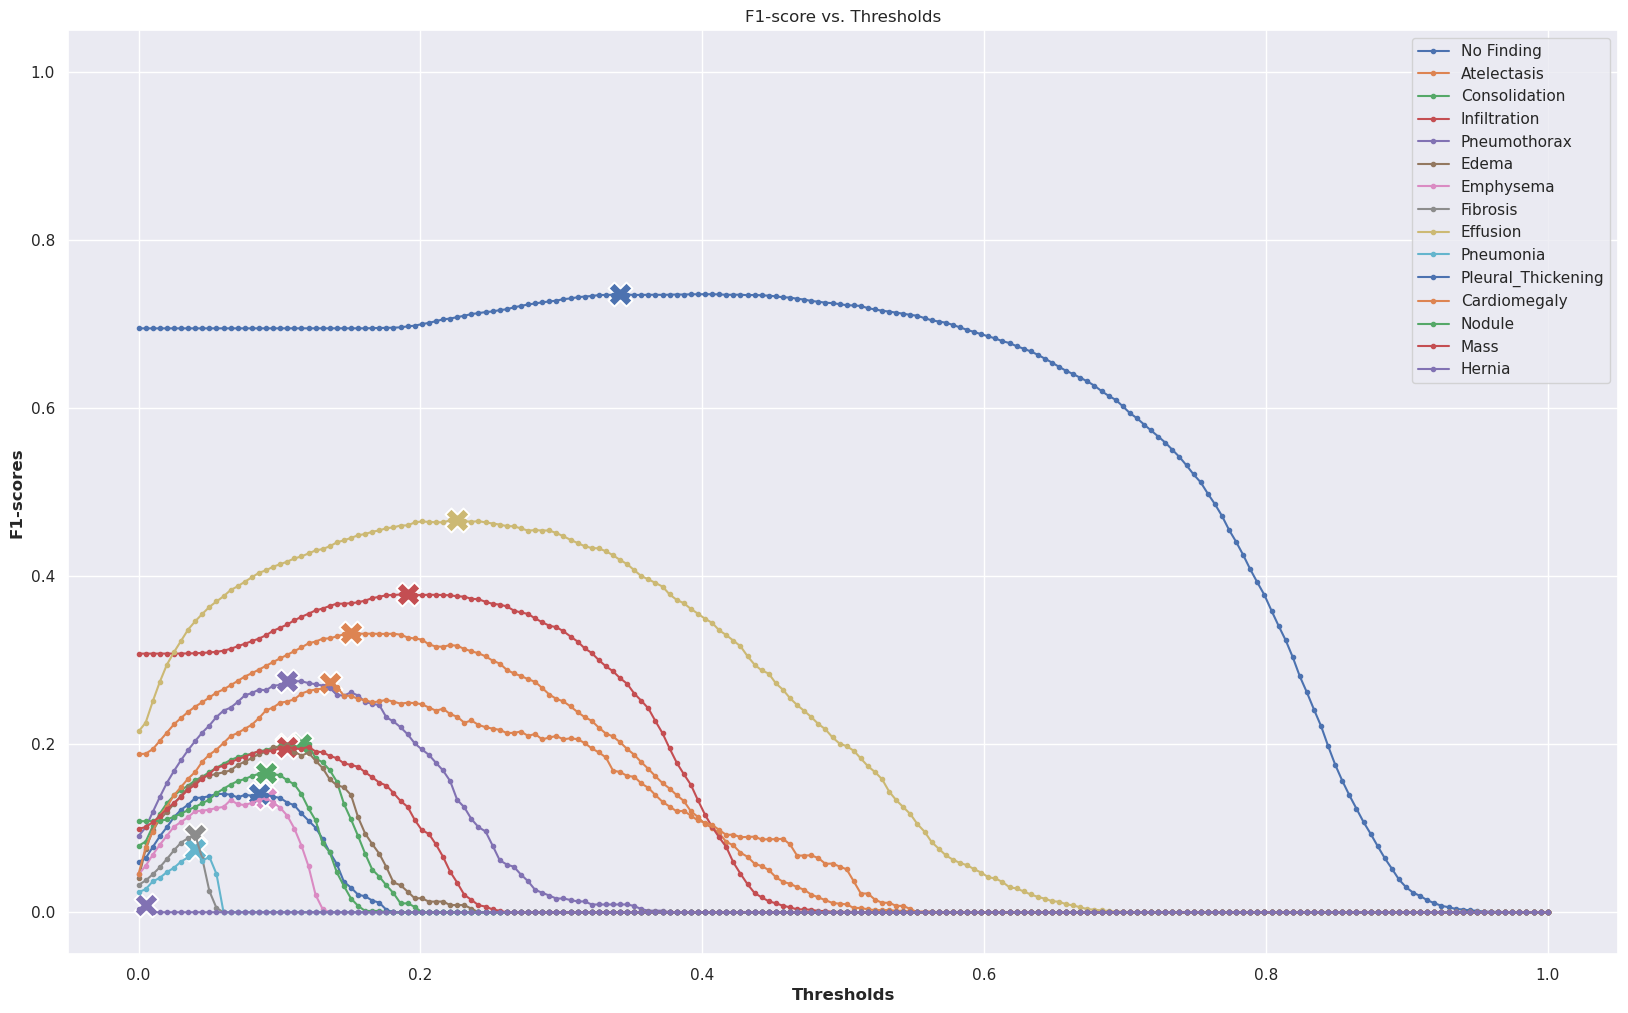

In [11]:
best_multiple_threshold = plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

In [12]:
best_multiple_threshold

[0.3417085427135678,
 0.1507537688442211,
 0.1155778894472361,
 0.1909547738693467,
 0.1055276381909547,
 0.1055276381909547,
 0.0904522613065326,
 0.0402010050251256,
 0.2261306532663316,
 0.0402010050251256,
 0.0854271356783919,
 0.135678391959799,
 0.0904522613065326,
 0.1055276381909547,
 0.0050251256281407]

ลองทำนายด้วยค่า Multiple threshold

In [13]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [14]:
import tensorflow as tf
from modules.dataset import Dataset

In [15]:
dataset = Dataset()

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

model_name = f"EfficientNetB0_None_fold_{fold_num}"

# Modeling
model = tf.keras.models.load_model(f"{ROOT_PATH}/results/models/{model_name}.h5")

2023-04-06 10:18:01.489449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 10:18:02.256465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8011 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:31:00.0, compute capability: 8.0


In [16]:
y_preds = model.predict(test_dataset)

2023-04-06 10:18:22.848995: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-06 10:18:23.760195: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-06 10:18:23.761429: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-06 10:18:23.761487: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-06 10:18:23.762599: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-06 10:18:23.762716: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 5s 30ms/step

2023-04-06 10:18:25.074458: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 46s 30ms/step


In [17]:
y_preds

array([[4.2773262e-01, 2.5281036e-01, 7.6642081e-02, ..., 3.8927734e-02,
        3.9367389e-02, 2.4909500e-03],
       [7.4058491e-01, 9.0876266e-02, 7.7672289e-03, ..., 4.3681040e-02,
        1.7460441e-02, 3.7029528e-03],
       [7.2026652e-01, 2.6956499e-02, 7.3669031e-03, ..., 3.8368043e-02,
        1.1895244e-02, 1.2429198e-03],
       ...,
       [8.5612690e-01, 9.7169252e-03, 5.1568085e-03, ..., 3.9248571e-02,
        1.2410050e-02, 3.9529798e-04],
       [4.3428773e-01, 1.0293041e-01, 2.3226792e-02, ..., 1.4017302e-01,
        1.5722871e-01, 3.9289268e-03],
       [3.4818360e-01, 1.6289492e-01, 1.5415004e-01, ..., 2.0412283e-02,
        1.2837459e-02, 1.4748181e-04]], dtype=float32)

In [18]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [19]:
best_multiple_threshold

[0.3417085427135678,
 0.1507537688442211,
 0.1155778894472361,
 0.1909547738693467,
 0.1055276381909547,
 0.1055276381909547,
 0.0904522613065326,
 0.0402010050251256,
 0.2261306532663316,
 0.0402010050251256,
 0.0854271356783919,
 0.135678391959799,
 0.0904522613065326,
 0.1055276381909547,
 0.0050251256281407]

In [20]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold[:5]}\n{threshold[5:10]}\n{threshold[10:]}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('predicted label', fontweight='bold')
        plt.ylabel('actual label', fontweight='bold')
    

In [21]:
import numpy as np
import tensorflow_addons as tfa

def run_confusion_metrics():
    fig = plt.figure(figsize=(35,20))
    thresh_value = best_multiple_threshold
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true,
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()
    return result

<Figure size 3500x2000 with 0 Axes>

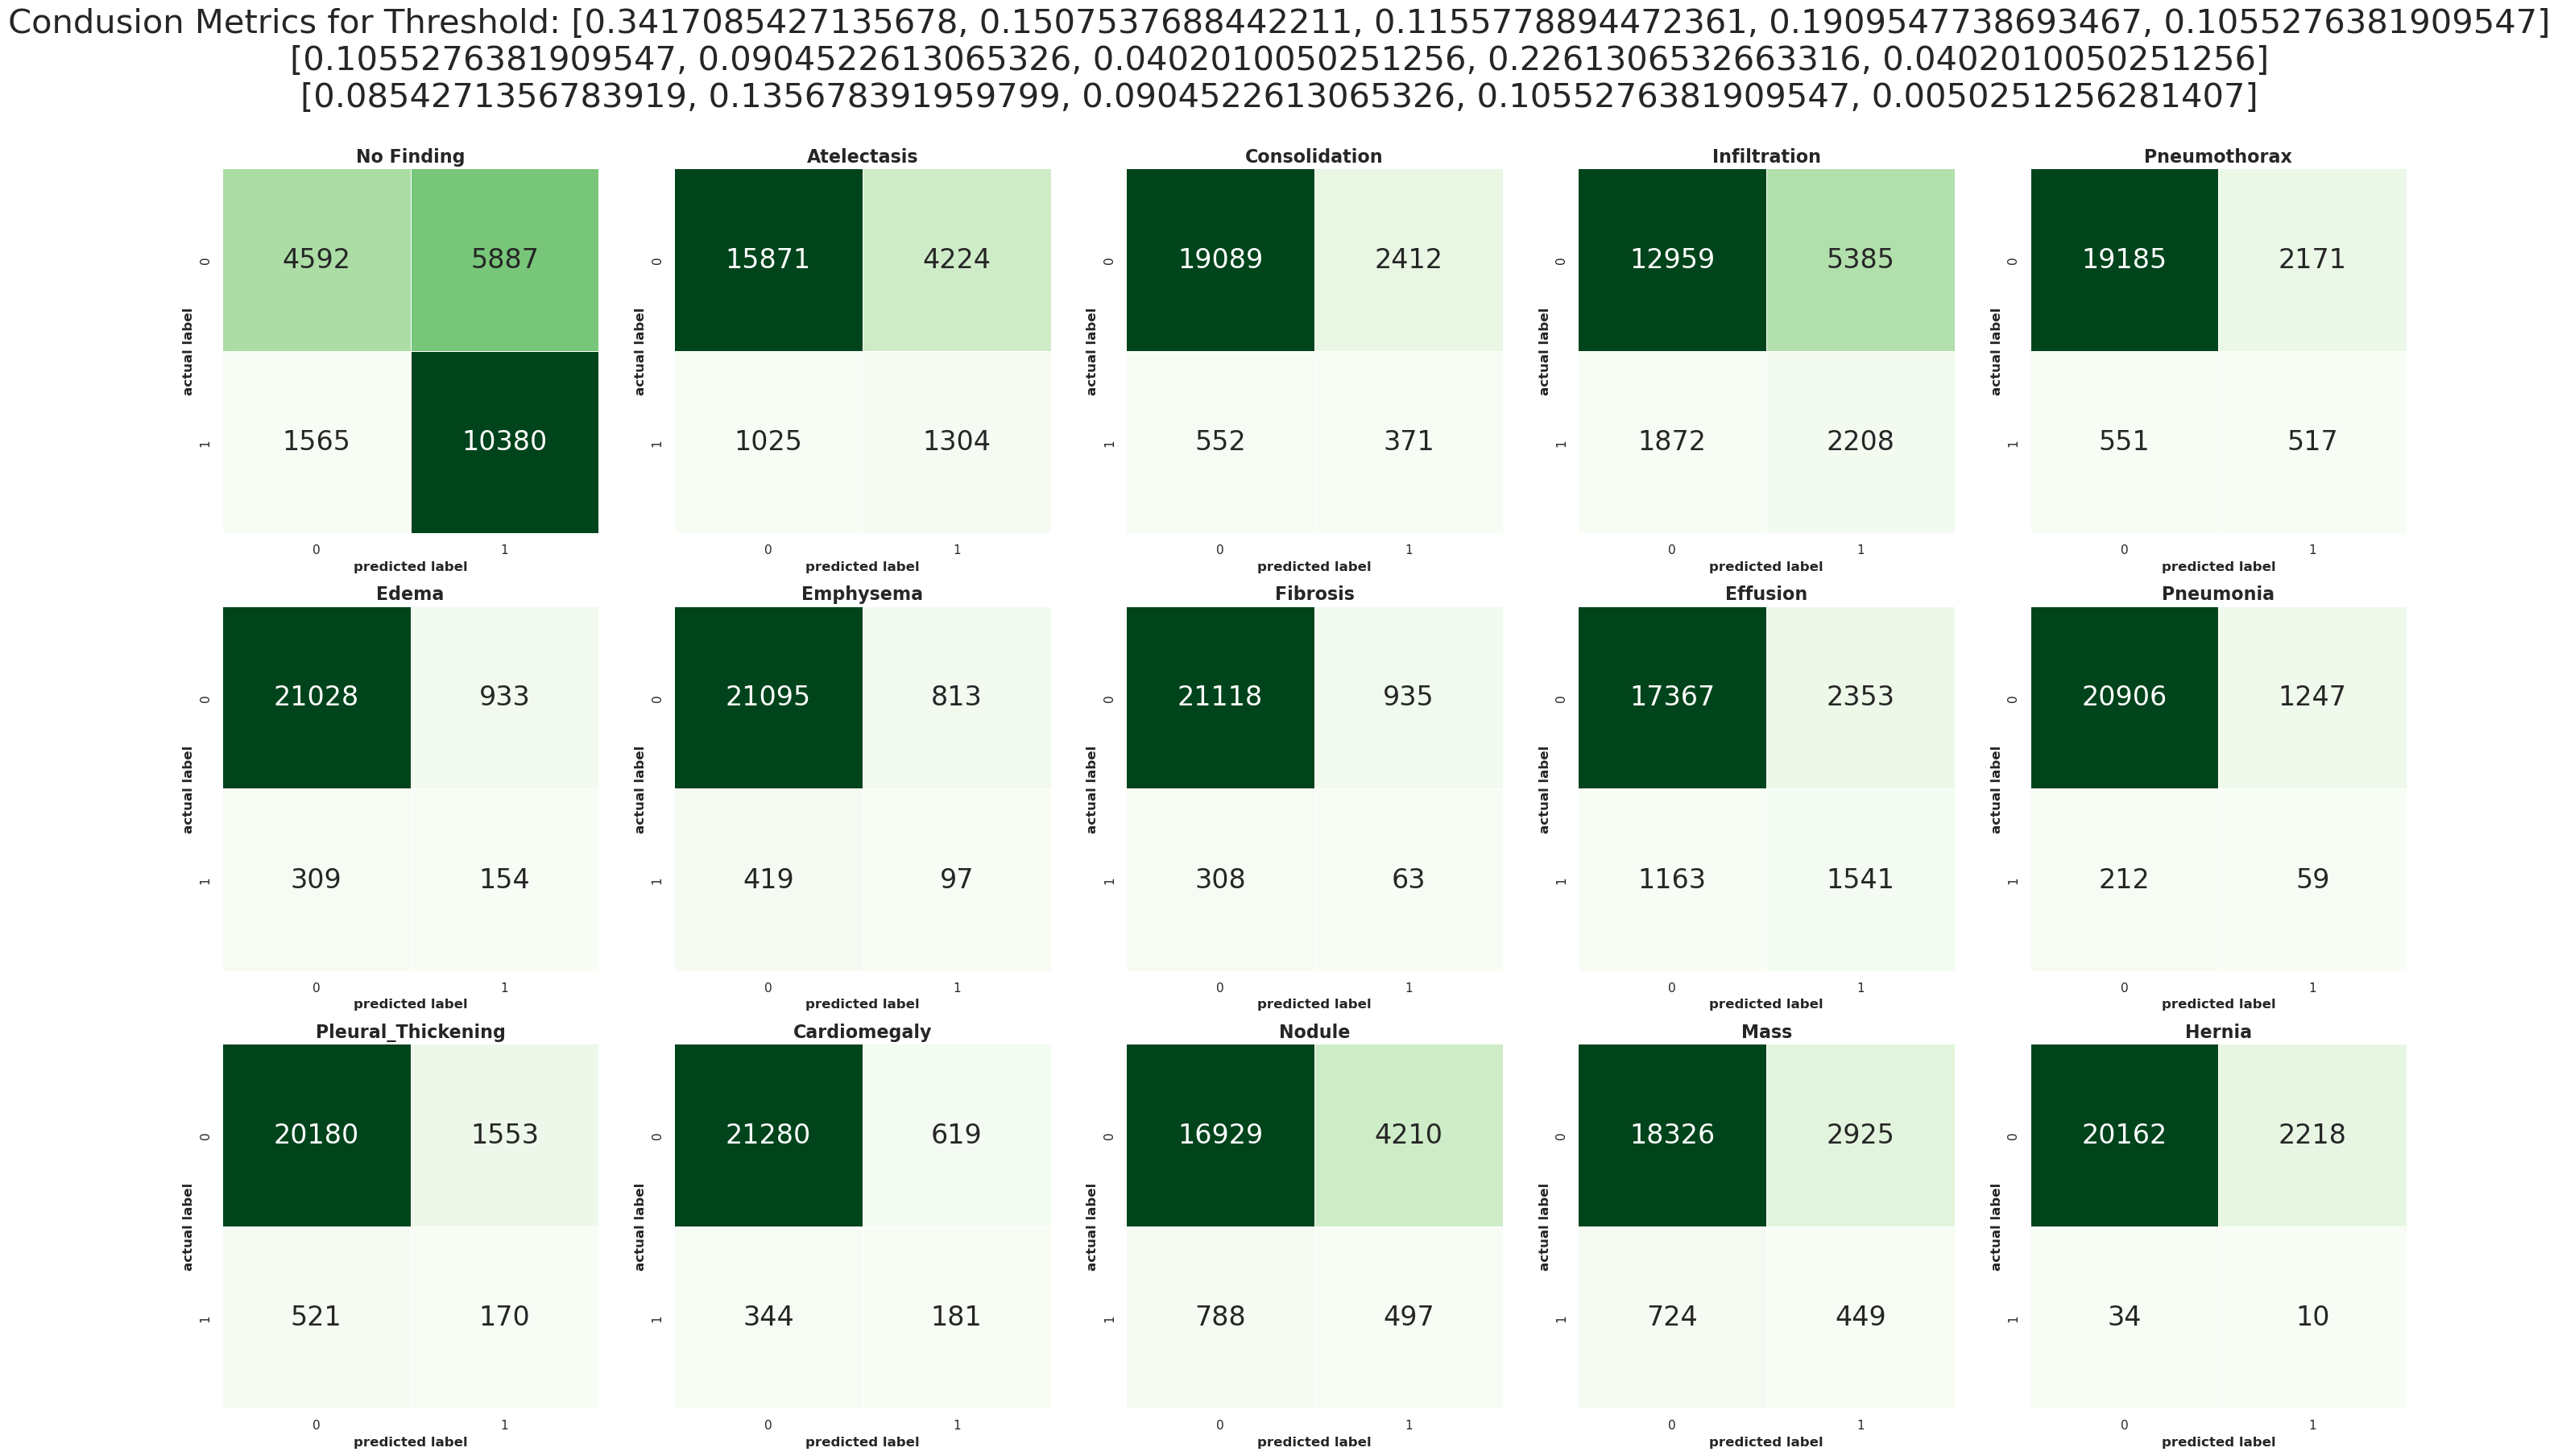

In [22]:
result = run_confusion_metrics()

Describe `tmp`
``` python
TN = tmp[0][0][0]
FP = tmp[0][0][1]
FN = tmp[0][1][0]
TP = tmp[0][1][1]
```

In [23]:
tmp = result.numpy()
tmp[0]

array([[ 4592.,  5887.],
       [ 1565., 10380.]], dtype=float32)

In [24]:
from modules.dataset import LABELS

accuracy = []
for i in range(len(tmp)):
    ls = (tmp[i][1][1] + tmp[i][0][0]) / (tmp[i][1][1] + tmp[i][0][0] + tmp[i][0][1] + tmp[i][1][0])
    accuracy.append(ls)
    print(f"{LABELS[i]} : {accuracy[i]*100} %")


No Finding : 66.76774621009827 %
Atelectasis : 76.59204602241516 %
Consolidation : 86.78202033042908 %
Infiltration : 67.6373541355133 %
Pneumothorax : 87.8612220287323 %
Edema : 94.46129202842712 %
Emphysema : 94.50588822364807 %
Fibrosis : 94.45683360099792 %
Effusion : 84.32037234306335 %
Pneumonia : 93.49358081817627 %
Pleural_Thickening : 90.75098037719727 %
Cardiomegaly : 95.70549130439758 %
Nodule : 77.71137952804565 %
Mass : 83.7272584438324 %
Hernia : 89.95718955993652 %


In [25]:
accuracy

[0.66767746,
 0.76592046,
 0.8678202,
 0.67637354,
 0.8786122,
 0.9446129,
 0.9450589,
 0.94456834,
 0.8432037,
 0.9349358,
 0.9075098,
 0.9570549,
 0.7771138,
 0.8372726,
 0.8995719]